In [71]:
import networkx as nx
import pandas as pd
import numpy as np

import snap as sn
from operator import itemgetter
import community as community


import glob
import os, os.path
import math


import scipy as sp
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


from scipy.stats import t

from mpl_toolkits.mplot3d import Axes3D


import matplotlib.pyplot as plt
from pylab import show
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [88]:
#Get the station data
ndata = pd.read_csv("networkdata.csv")

In [89]:
ndata.head(2)
#station_ids rep unique stations across lines, not unique stations per line - all available transfers not represented

,station_id,node_id,previous_node_id,next_node_id,url,line_name,line_num,Boro,transfer_line_nums,service,name
0,1_Start,1_Start,NaN,1_1,http://web.mta.info/nyct/service/oneline.htm,Broadway- 7 Avenue Local,1,BRONX,0,Full Time,Van Cortlandt Park-242 Street
1,1_1,1_1,1_Start,1_2,http://web.mta.info/nyct/service/oneline.htm,Broadway- 7 Avenue Local,1,BRONX,0,Full Time,238 Street


In [90]:
#initialize the graph
G.clear()
G = nx.MultiDiGraph()

In [91]:
#add nodes and attributes
for i in range(0,len(ndata)):
    G.add_node(ndata.node_id[i], name = ndata.name[i], Line = ndata.line_num[i], boro = ndata.Boro[i], Service = ndata.service[i],Transfers = ndata.transfer_line_nums[i])


In [92]:
#clear the nodes from G
#G.clear()
#show the nodes in G
#G.nodes(data=True)

In [93]:
#ADD THE EDGES
for i in range(0,len(ndata.node_id)):
    if pd.notnull(ndata.previous_node_id[i]):
        G.add_edge(ndata.node_id[i],ndata.previous_node_id[i])
    if pd.notnull(ndata.next_node_id[i]):
        G.add_edge(ndata.node_id[i],ndata.next_node_id[i])



In [94]:
print nx.info(G)

Name: 
Type: MultiDiGraph
Number of nodes: 528
Number of edges: 1712
Average in degree:   3.2424
Average out degree:   3.2424


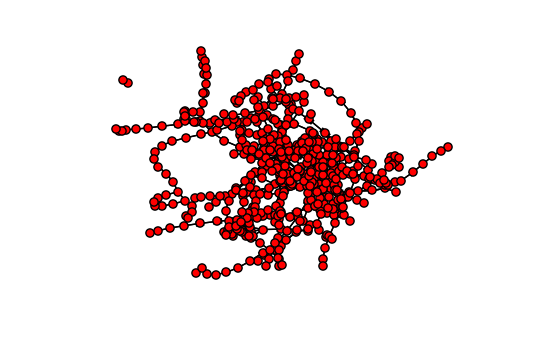

In [95]:
plt.axis("off")
spring_pos = nx.spring_layout(G)
nx.draw_networkx(G, pos = spring_pos, with_labels = False, node_size = 35)

In [96]:
#Method 1 - betweenness_centrality
#compute the betweeness centrality to determine who is the most "important" individual in the network.
#using betweenness centrality is a measure of how many shortest paths pass through a particular vertex.
#Method from http://glowingpython.blogspot.com/2013/02/betweenness-centrality.html

def most_important(G):

  ranking = nx.betweenness_centrality(G).items()
  
  r = [x[1] for x in ranking]
  m = sum(r)/len(r) # mean centrality
  t = m*2 # threshold, we keep only the nodes with 2 times the mean
  Gt = G.copy()
  for k, v in ranking:
    if v < t:
      Gt.remove_node(k)
  return Gt



In [97]:
dominant = most_important(G)

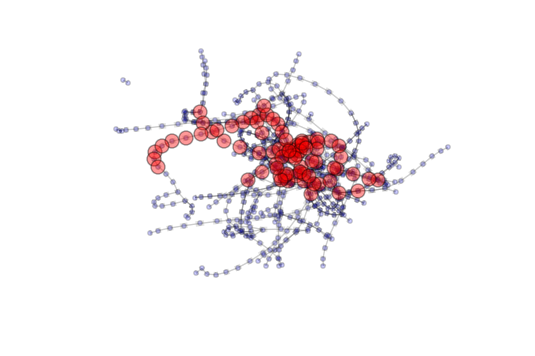

In [98]:
plt.axis("off")

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,spring_pos,node_color='b',alpha=0.2,node_size=10)
nx.draw_networkx_edges(G,spring_pos,alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(dominant,spring_pos,node_color='r',alpha=0.4,node_size=100)
# also the labels this time
#nx.draw_networkx_labels(dominant,spring_pos,font_size=10,font_color='b')
show()

In [99]:
#uses scipi arc pak to determine most important node by spectral theory power method
def most_important(G):

  ranking = nx.eigenvector_centrality_numpy(G).items()
  
  r = [x[1] for x in ranking]
  m = sum(r)/len(r) # mean centrality
  t = m*3 # threshold, we keep only the nodes with 100 times the mean
  Gt = G.copy()
  for k, v in ranking:
    if v < t:
      Gt.remove_node(k)
  return Gt

dominante3 = most_important(G)

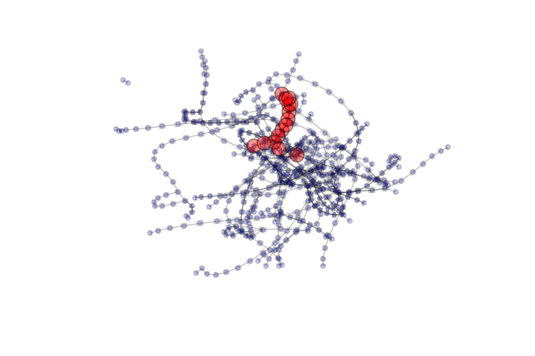

In [100]:
plt.axis("off")

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,spring_pos,node_color='b',alpha=0.2,node_size=10)
nx.draw_networkx_edges(G,spring_pos,alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(dominante3,spring_pos,node_color='r',alpha=0.4,node_size=100)
# also the labels this time
#nx.draw_networkx_labels(dominante3,spring_pos,font_size=10,font_color='b')
show()

In [101]:
#1) Compute the exponential adjacency matrix (how connected is the graph)
node_and_degree=G.degree()
snl = sorted(node_and_degree)
am = nx.adjacency_matrix(G, nodelist=snl)

In [102]:
#2) #Apply a clustering algorithm using the rows of the adjacency matrix
sclusterlabels = spectral_clustering(am, n_clusters=4, n_components=None, eigen_solver=None, random_state=None, n_init=10, eigen_tol=0.0, assign_labels='kmeans')

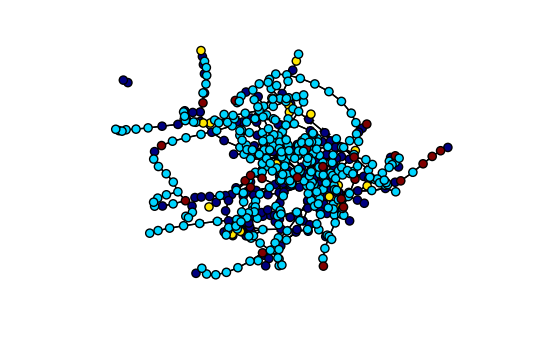

In [103]:
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = sclusterlabels, with_labels = False, node_size = 35)